In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
#import psycopg2
import matplotlib.pyplot as plt
import time
import re
import scipy
from datetime import time, timedelta
import seaborn as sns
import datetime as dt
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def trans_id(df):
    for i in ['subject_id','hadm_id','stay_id']:
        if i in df.columns.tolist():
            if df[i].dtype == object:
                if ((df[i]== 'None')|(df[i]== 'Null')).any():
                    df[i].replace('None',np.nan,inplace = True)
                    df[i].replace('Null',np.nan,inplace = True)
                    df[i] = df[i].astype(float)
                else:
                    df[i] = df[i].astype(float)

In [3]:
def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return np.datetime64(t)

In [4]:
def trans_float(df):
    for i in df.columns:
        if df[i].dtype == object:
            if ((df[i]== 'None')|(df[i]== 'Null')).any():
                df[i].replace('None',np.nan,inplace = True)
                df[i].replace('Null',np.nan,inplace = True)
                df[i] = df[i].astype(float)
            else:
                df[i] = df[i].astype(float)

In [5]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('val_df.csv')

In [6]:
train_df['previous_mdr_90d'] = (train_df['previous_mdrpos_lessthan90d'] + train_df['previous_mdrneg_lessthan90d']).apply(lambda x:1 if x>=1 else 0)
val_df['previous_mdr_90d'] = (val_df['previous_mdrpos_lessthan90d'] + val_df['previous_mdrneg_lessthan90d']).apply(lambda x:1 if x>=1 else 0)

In [7]:
#修改后重新输出
train_df.to_csv('train_df.csv',index = False)
val_df.to_csv('val_df.csv',index = False)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

In [9]:
def xgb_test(label, features):
    train_df,test_df = train_test_split(mdro,\
                                            stratify = mdro[label], \
                                                test_size = 0.2, random_state = 2021)
    xgboost = XGBClassifier(n_jobs = -1, n_estimators=50, max_depth=5,learning_rate=0.1,min_child_weight=6,tree_method = 'gpu_hist',gpu_id = 0,
                       random_state= 2021)
    x_train = train_df[features]
    x_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    xgboost.fit(x_train,y_train)

    predict_test = xgboost.predict_proba(x_test)

    predict_train = xgboost.predict_proba(x_train)

    print('训练集AUC为：%.3f'%roc_auc_score(y_train,predict_train[:,1]))

    print('测试集AUC为：%.3f'%roc_auc_score(y_test,predict_test[:,1]))

In [10]:
train_df.columns

Index(['GENDER', 'AGE', 'BMI', 'BODY_WEIGHT', 'previous_mdrpos_lessthan90d',
       'previous_mdrneg_lessthan90d', 'icustay_rank', 'hospstay_seq',
       'los_hosp_beforeicu', 'myocardial_infarct', 'congestive_heart_failure',
       'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease', 'rheumatic_disease',
       'peptic_ulcer_disease', 'severe_liver_disease', 'mild_liver_disease',
       'diabetes_with_cc', 'diabetes_without_cc', 'paraplegia',
       'metastatic_solid_tumor', 'malignant_cancer', 'aids',
       'charlson_comorbidity_index', 'ALP', 'ALT', 'APPT', 'AST', 'BNP', 'CRP',
       'D_dimer', 'INR', 'LYN', 'PA', 'PCT', 'IL_6', 'PT', 'PTT', 'albumin',
       'amylase', 'bands', 'basophil', 'bilirubin', 'bilirubin_direct', 'ca',
       'chloride', 'ck', 'ck_mb', 'creatinine', 'eosinophil', 'fibrinogen',
       'gamma_GT', 'glucose', 'hct_pcv', 'hemoglobin', 'lipase', 'mb', 'mch',
       'mchc', 'mcv', 'mg', 'monocytes', 'mpv', '

In [11]:
features_tot = ['GENDER', 'AGE','BMI', 'previous_mdr_90d', 'icustay_rank', 'los_hosp_beforeicu','hospstay_seq',
       'myocardial_infarct', 'congestive_heart_failure',
       'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease', 'rheumatic_disease',
       'peptic_ulcer_disease', 'severe_liver_disease', 'mild_liver_disease',
       'diabetes_with_cc', 'diabetes_without_cc', 'paraplegia',
       'metastatic_solid_tumor', 'malignant_cancer','charlson_comorbidity_index',  'ALP', 'ALT',
       'APPT', 'AST', 'BNP', 'CRP', 'D_dimer', 
        'INR', 
        #'LYN',
        'PA', 'PCT',
       'IL_6',
        'PT', 'PTT', 
'monocytes_abs',
 'neutrophils_abs',
 'eosinophil_abs',
 'basophil_abs',
 'lymphocytes_abs',
 'RPR',
 'NLR',
 'shock_index',
       'albumin', 'amylase', 
        #'bands', 'basophil',
       'bilirubin', 'bilirubin_direct', 'ca', 'chloride', 'ck', 'ck_mb',
       'creatinine', 
                #'eosinophil', 
                'fibrinogen', 'gamma_GT', 'glucose',
       'hct_pcv', 'hemoglobin', 'lipase', 'mb', 'mch', 'mchc', 'mcv', 'mg',
       #'monocytes',
                'mpv', 'p', 'platelet', 'potassium', 'rbc', 'rdw',
       'sodium', 'urea', 'wbc', 'Temperature', 'RR', 'HR', 'DBP', 'SBP']

In [12]:
# train_df,test_df = train_test_split(dev_df,\
#                                         stratify = dev_df[['stay_chart_included_mdr','stay_chart_included_mdr_pos_tot','stay_chart_included_mdr_neg_tot']],\
#                                             test_size = 0.2, random_state = 2021)

x_train = train_df[features_tot]
x_test = val_df[features_tot]
# y_train = train_df[['culture_positive', 'negative', 'positive', 'fungi']]
# y_test = val_df[['culture_positive', 'negative', 'positive', 'fungi']]

y_train = train_df['stay_chart_included_mdr']
y_test = val_df['stay_chart_included_mdr']

In [13]:
val_df['stay_chart_included_mdr_pos_tot'].value_counts()

0    1111
1      37
Name: stay_chart_included_mdr_pos_tot, dtype: int64

In [14]:
val_df['stay_chart_included_mdr_neg_tot'].value_counts()

0    1024
1     124
Name: stay_chart_included_mdr_neg_tot, dtype: int64

In [15]:
train_df['stay_chart_included_mdr'].value_counts()

0    2111
1     277
Name: stay_chart_included_mdr, dtype: int64

In [16]:
val_df['stay_chart_included_mdr'].value_counts()

0    1002
1     146
Name: stay_chart_included_mdr, dtype: int64

# permutation

In [17]:
rf= RandomForestClassifier(random_state=2023,min_samples_split=10,max_depth = 3, n_estimators=30, n_jobs = -1)

In [18]:
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, min_samples_split=10, n_estimators=30,
                       n_jobs=-1, random_state=2023)

In [19]:
predict_test = rf.predict_proba(x_test)

In [20]:
predict_train = rf.predict_proba(x_train)

In [21]:
roc_auc_score(y_train,predict_train[:,1])

0.8237571120501687

In [22]:
roc_auc_score(y_test,predict_test[:,1])

0.7775818226560578

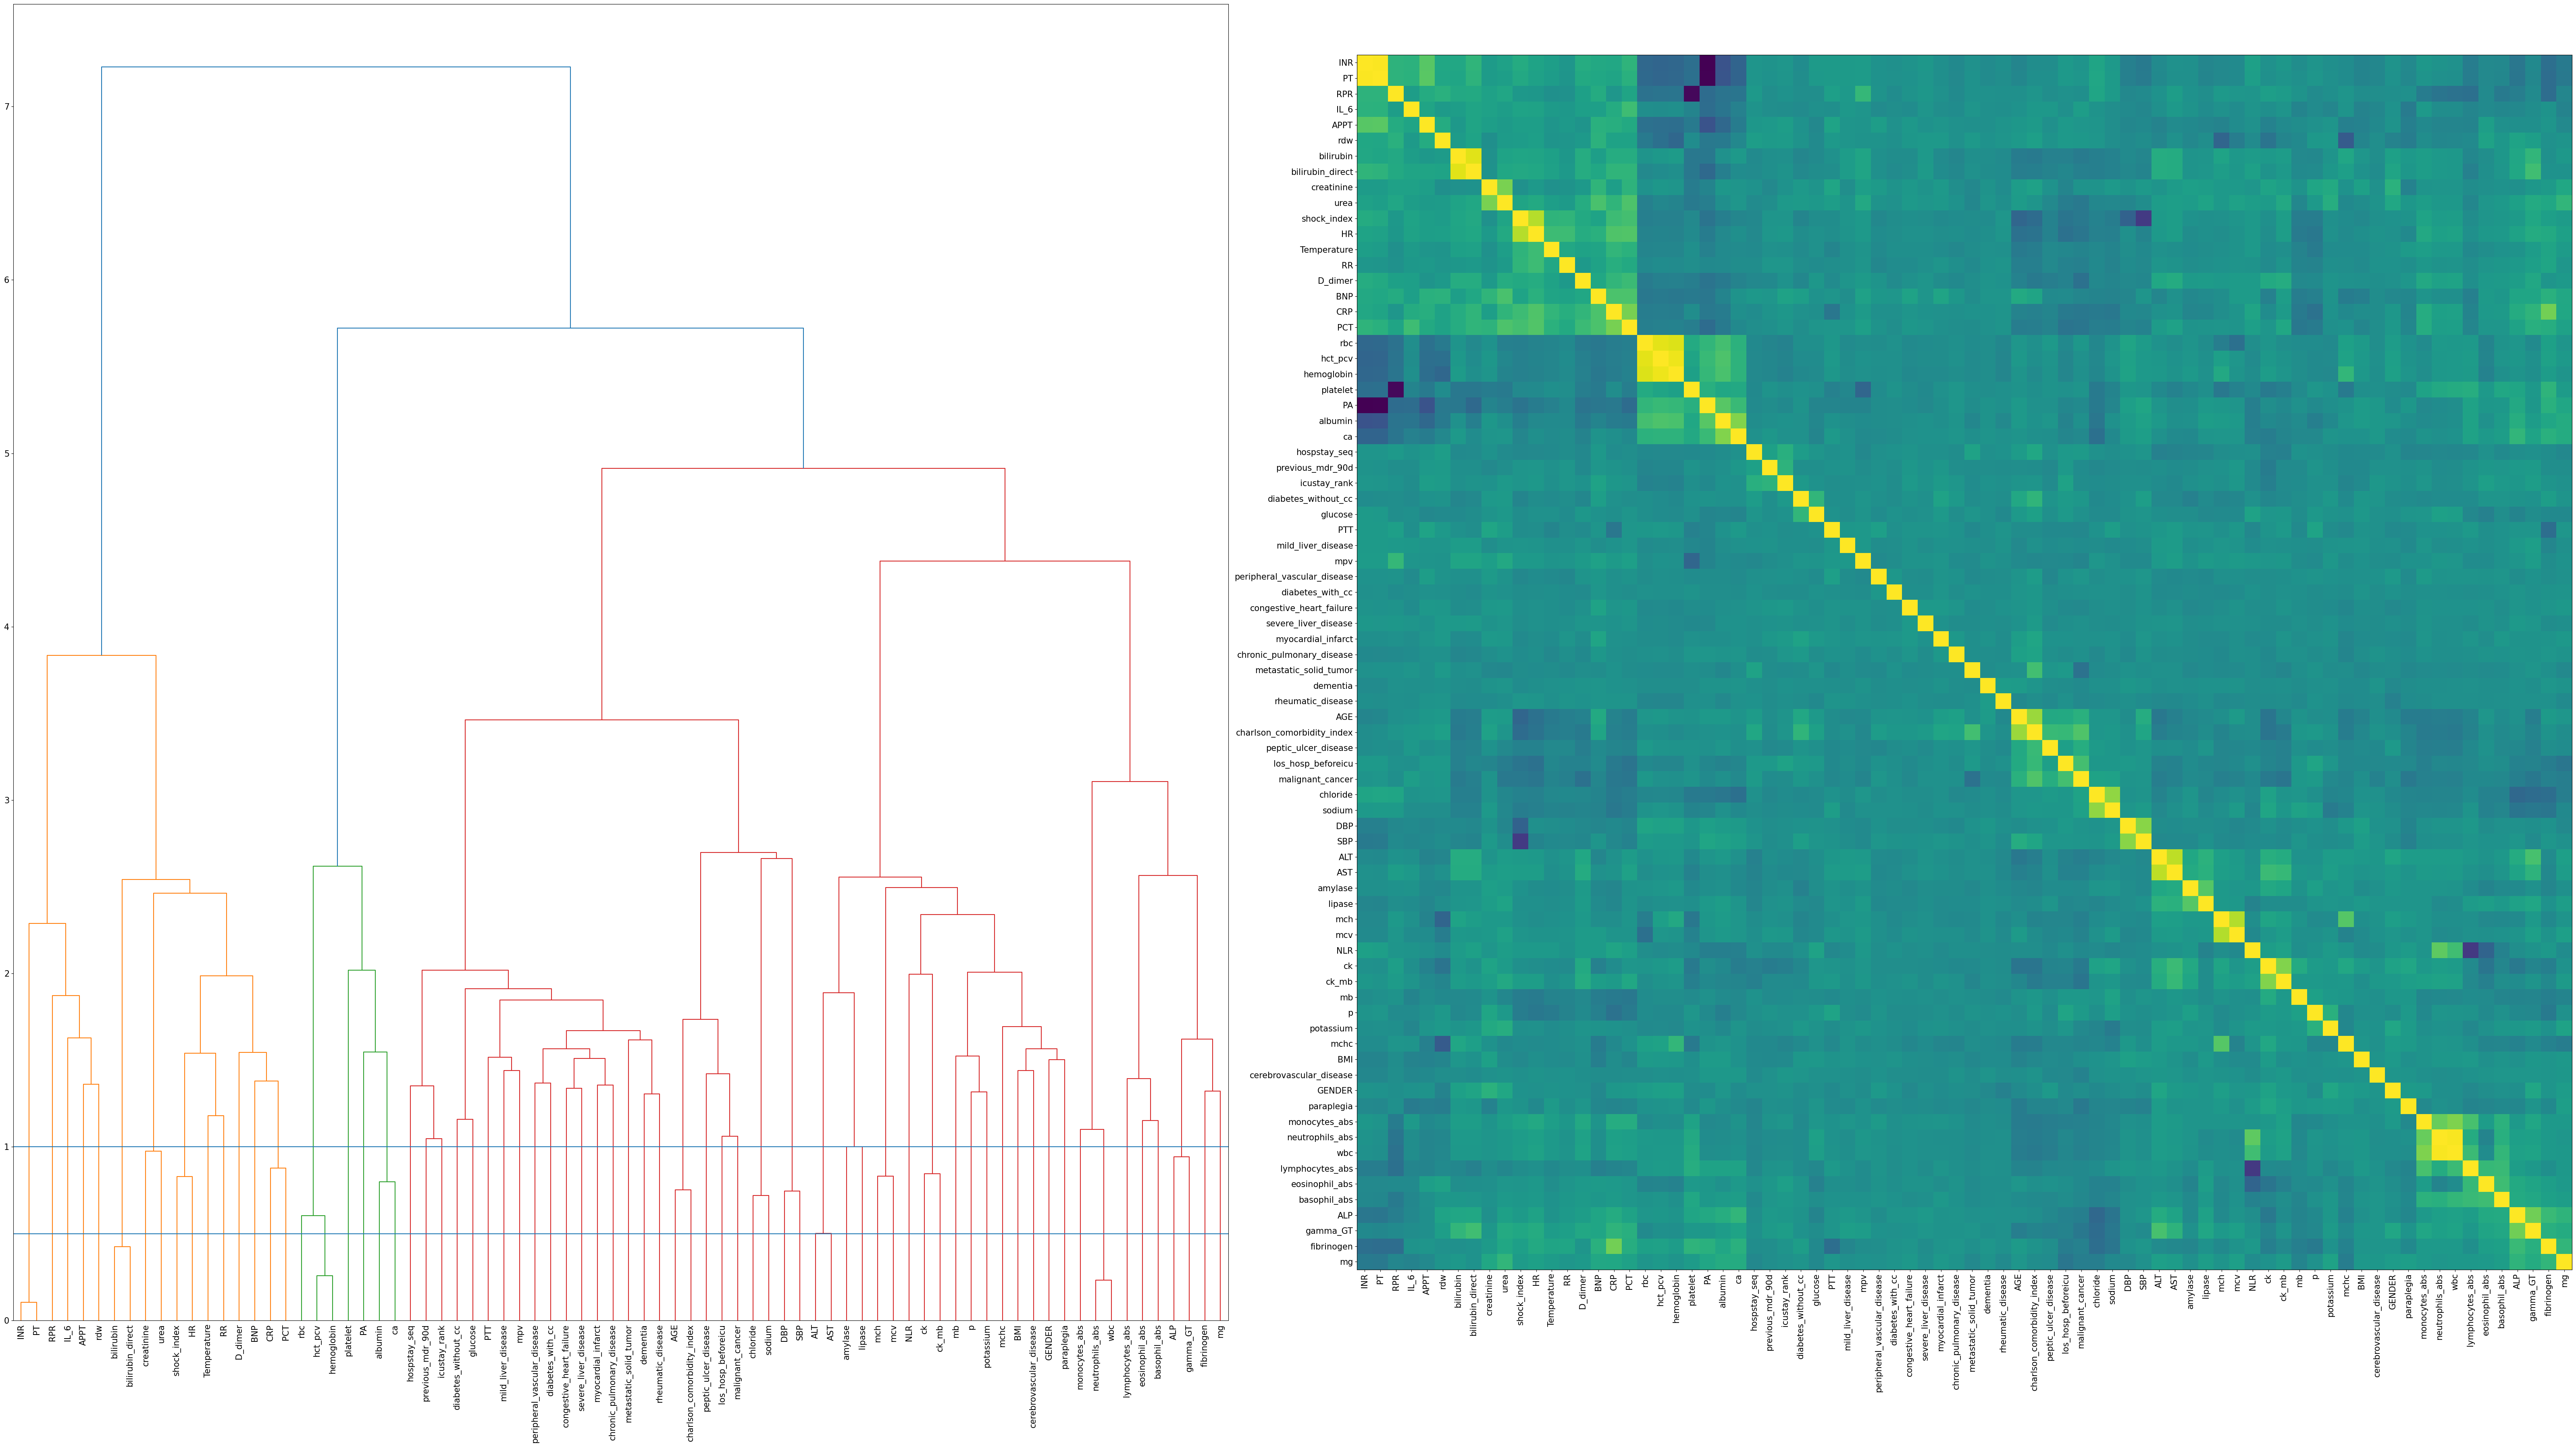

In [23]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(64, 36))
corr = spearmanr(x_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=features_tot, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax1.axhline(1)
ax1.axhline(0.5)
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
fig.tight_layout()
plt.show()

In [24]:
cluster_ids = hierarchy.fcluster(corr_linkage, 0.5, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features_col = [v[0] for v in cluster_id_to_feature_ids.values()]

In [50]:
features_tot = ['GENDER', 'AGE','BMI', 'previous_mdr_90d',
        'icustay_rank', 'los_hosp_beforeicu','hospstay_seq',
       'myocardial_infarct', 'congestive_heart_failure',
       'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease', 'rheumatic_disease',
       'peptic_ulcer_disease', 'severe_liver_disease', 'mild_liver_disease',
       'diabetes_with_cc', 'diabetes_without_cc', 'paraplegia',
       'metastatic_solid_tumor', 'malignant_cancer','charlson_comorbidity_index',
       'ALP', 'ALT',
       'APPT', #'AST',
        'BNP', 'CRP', 'D_dimer', 
        'INR', 
        #'LYN', 
                'PA', 'PCT',
       'IL_6',
        'PT', 'PTT', 
       'albumin', #'amylase',
                #'bands', 'basophil',
       'bilirubin',# 'bilirubin_direct',
                'ca', 'chloride', 'ck', 'ck_mb',
       'creatinine', 
               # 'eosinophil',
                'fibrinogen', 'gamma_GT', 'glucose',
       #'hct_pcv', 
        'hemoglobin',
        #'lipase',
        'mb', 'mch', 'mchc', 'mcv', 'mg',
       #'monocytes',
                'mpv', 'p', 'platelet', 'potassium',
        #'rbc',
        'rdw',
       'sodium', 'urea', 'wbc', 'Temperature', 'RR', 'HR', 'DBP', 'SBP',
               'monocytes_abs',
 'neutrophils_abs',
 'eosinophil_abs',
 'basophil_abs',
 'lymphocytes_abs',
 'RPR',
 'NLR',
 'shock_index']

In [51]:
x_train_sel = x_train.loc[:, features_tot]
x_test_sel = x_test.loc[:, features_tot]

clf_sel = RandomForestClassifier(random_state=2023,min_samples_split=10,max_depth = 4, n_estimators=40, n_jobs = -1)
clf_sel.fit(x_train_sel, y_train)

RandomForestClassifier(max_depth=4, min_samples_split=10, n_estimators=40,
                       n_jobs=-1, random_state=2023)

In [52]:
predict_train_sel = clf_sel.predict_proba(x_train_sel)
predict_test_sel = clf_sel.predict_proba(x_test_sel)

In [53]:
roc_auc_score(y_train, predict_train_sel[:,1]),\
roc_auc_score(y_test, predict_test_sel[:,1])

(0.8597188185659781, 0.7835356683892489)

In [54]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf_sel, x_train_sel,y_train,scoring = 'roc_auc', n_repeats= 30,n_jobs =-1,  random_state=2023)

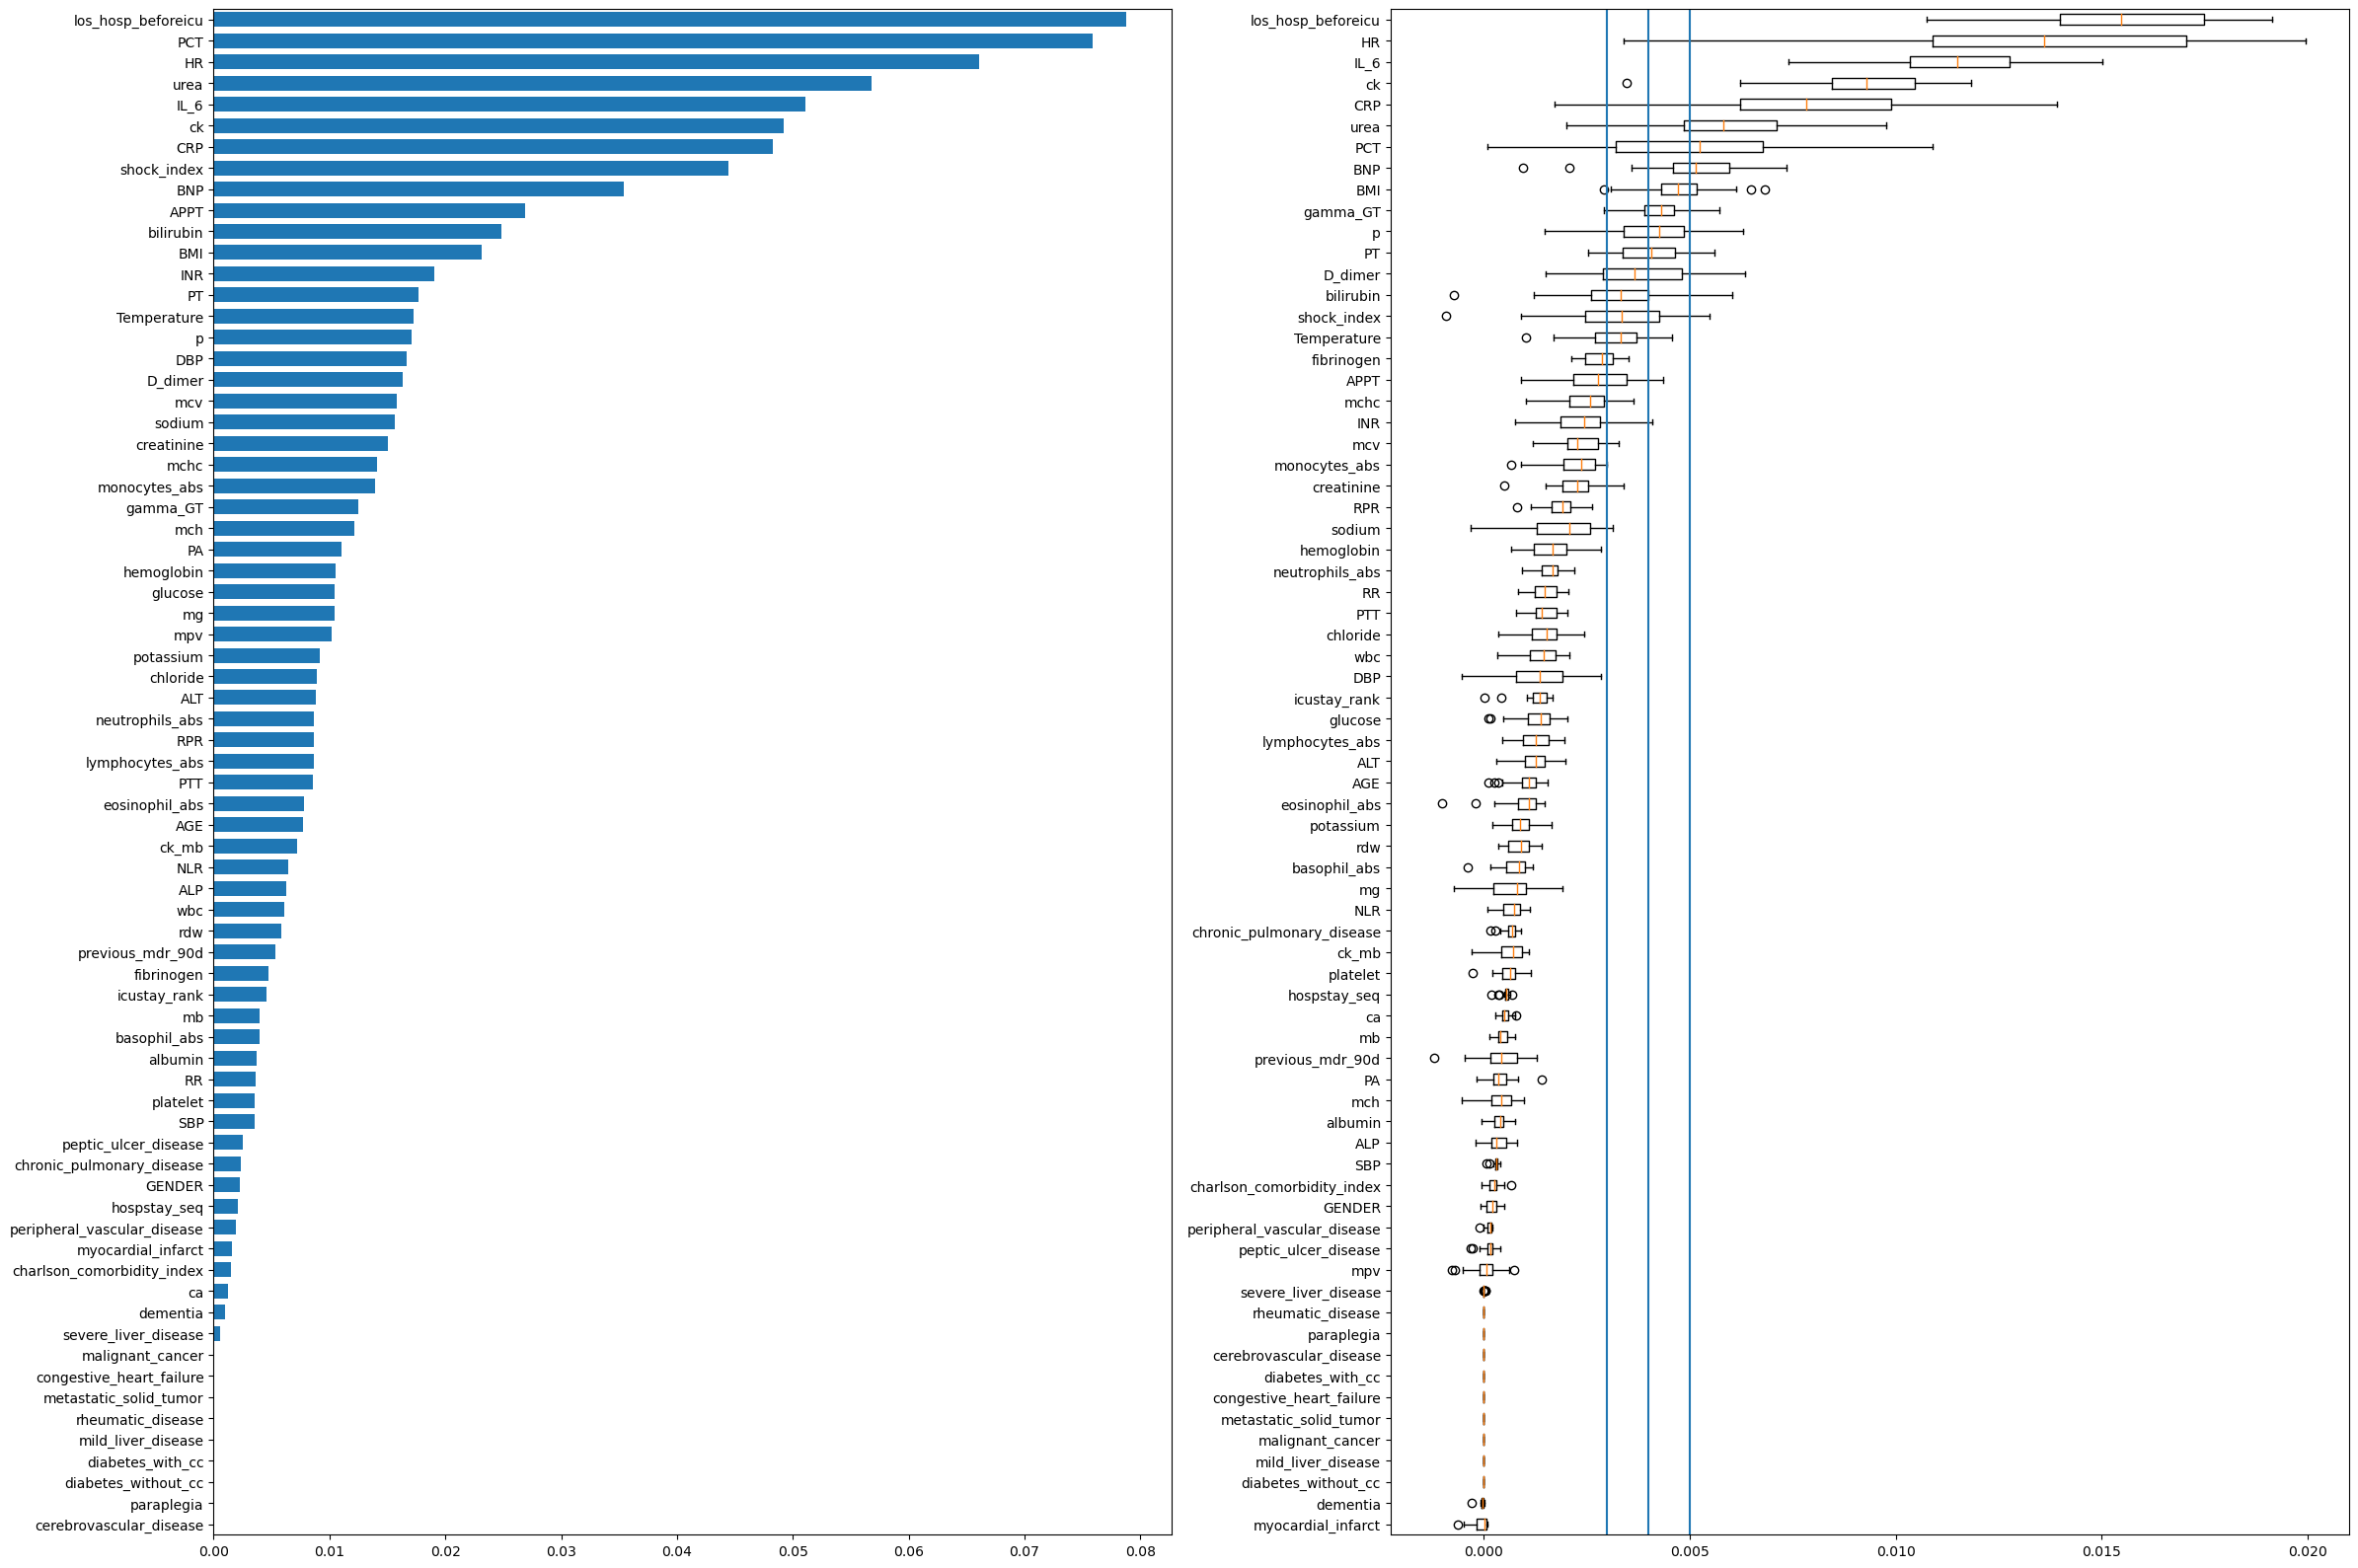

In [55]:
perm_sorted_idx = r.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))
ax1.barh(tree_indices,
         clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(x_train_sel.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax2.boxplot(r.importances[perm_sorted_idx].T, vert=False,
            labels=x_train_sel.columns[perm_sorted_idx])
ax2.axvline(0.005)
ax2.axvline(0.004)
ax2.axvline(0.003)
fig.tight_layout()
plt.show()

In [56]:
features = x_train_sel.columns[r.importances_mean>0.002].to_list()

In [57]:
features = x_train_sel.columns[perm_sorted_idx][-25:].to_list()

In [58]:
#features = x_train_sel.columns[r.importances_mean>0.005].to_list()

In [59]:
# features = ['age',
#  'hospstay_seq',
#  'previous_mdrpos_lessthan90d',
#  'previous_mdrneg_lessthan90d',
#  'history_assistive_devices_Wheelchair',
#  'history_past_COPD',
# #  'carbapenem',
# #  'ceph_4th',
# #  'ceph_1st',
# #  'linezolid',
# #  'piperacillin_tazobactam',
# #  'vancomycin',
#  'bun',
#  'po2',
#  'rdw',
#  'ant_duration',
# # 'ant_1stday',
#  'surgical',
#  'ent_nut']

In [60]:
#del features[-1]

In [61]:
features

['sodium',
 'RPR',
 'creatinine',
 'monocytes_abs',
 'mcv',
 'INR',
 'mchc',
 'APPT',
 'fibrinogen',
 'Temperature',
 'shock_index',
 'bilirubin',
 'D_dimer',
 'PT',
 'p',
 'gamma_GT',
 'BMI',
 'BNP',
 'PCT',
 'urea',
 'CRP',
 'ck',
 'IL_6',
 'HR',
 'los_hosp_beforeicu']

In [62]:
x_val = val_df[features]
y_val = val_df['stay_chart_included_mdr']

In [63]:
x_train_f = x_train[features]
x_test_f = x_test[features]
y_train = train_df['stay_chart_included_mdr']
y_test = val_df['stay_chart_included_mdr']

clf_f = RandomForestClassifier(random_state=2021,min_samples_split=10,max_depth = 5, n_estimators=100, n_jobs = -1)
clf_f.fit(x_train_f, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_jobs=-1,
                       random_state=2021)

In [64]:
predict_train_f = clf_f.predict_proba(x_train_f)
predict_test_f = clf_f.predict_proba(x_test_f)

In [65]:
roc_auc_score(y_train, predict_train_f[:,1]),\
roc_auc_score(y_test, predict_test_f[:,1])

(0.8980969547513712, 0.7808082465206574)